In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences
import statsmodels.api as sm
from scipy import stats
import math
from math import pi
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2,vq, whiten
import geopandas as gpd
import h5py
import boto.s3
import glob
import boto3
from zipfile import ZipFile
import shutil

In [2]:
# Show all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [15]:
# Showing the entire number in dataframe
pd.set_option('float_format', '{:f}'.format)

#### Baseline

In [3]:
%%time
s3 = boto3.client("s3")
key = "pilates-outputs/sfbay-baseline-2022124/inexus/sfbay_baseline_default-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sfbase = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:4: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 36s
Wall time: 1min 37s


#### Extra checks

In [4]:
conditions  = [(sfbase['primary_purpose_x'] == 'work'),(sfbase['primary_purpose_x'] == 'univ'),
               (sfbase['primary_purpose_x'] == 'school'),(sfbase['primary_purpose_x'] == 'escort'),
              (sfbase['primary_purpose_x'] == 'shopping'),(sfbase['primary_purpose_x'] == 'eatout'),
              (sfbase['primary_purpose_x'] == 'othmaint'),(sfbase['primary_purpose_x'] == 'social'),
              (sfbase['primary_purpose_x'] == 'othdiscr'),(sfbase['primary_purpose_x'] == 'atwork')]
 
                                                                   
choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]

In [5]:
sfbase['c_ivt'] = np.select(conditions, choices, default=np.nan)

In [16]:
sfbase['value_of_time'].describe()

count   2462814.000000
mean          9.621875
std           9.140774
min           0.667000
25%           3.619946
50%           6.655961
75%          12.159933
max          50.000000
Name: value_of_time, dtype: float64

In [27]:
%%time 
#this alpha will convert the INEXUS values to cents per minute
sfbase['alpha'] = 0.6 *(sfbase['c_ivt'])/(sfbase['value_of_time'])

CPU times: total: 719 ms
Wall time: 626 ms


In [28]:
sfbase['Potential_INEXUS_in_dollar_2023'] = ((sfbase['logsum_trip_Potential_INEXUS']/sfbase['alpha'])/100)*1.75

In [29]:
sfbase['Potential_INEXUS_in_dollar_2023'].describe()

count   2462814.000000
mean          4.375769
std          17.521565
min        -145.957341
25%          -1.010055
50%           2.454819
75%           7.904748
max        1815.560262
Name: Potential_INEXUS_in_dollar_2023, dtype: float64

In [31]:
sfbase_plot = sfbase[(sfbase['Potential_INEXUS_in_dollar_2023']>-80)&(sfbase['Potential_INEXUS_in_dollar_2023']<100)]

In [32]:
sfbase_plot['Potential_INEXUS_in_dollar_2023'].describe()

count   2452440.000000
mean          4.026435
std          14.003405
min         -79.994026
25%          -1.006729
50%           2.442634
75%           7.833830
max          99.996851
Name: Potential_INEXUS_in_dollar_2023, dtype: float64

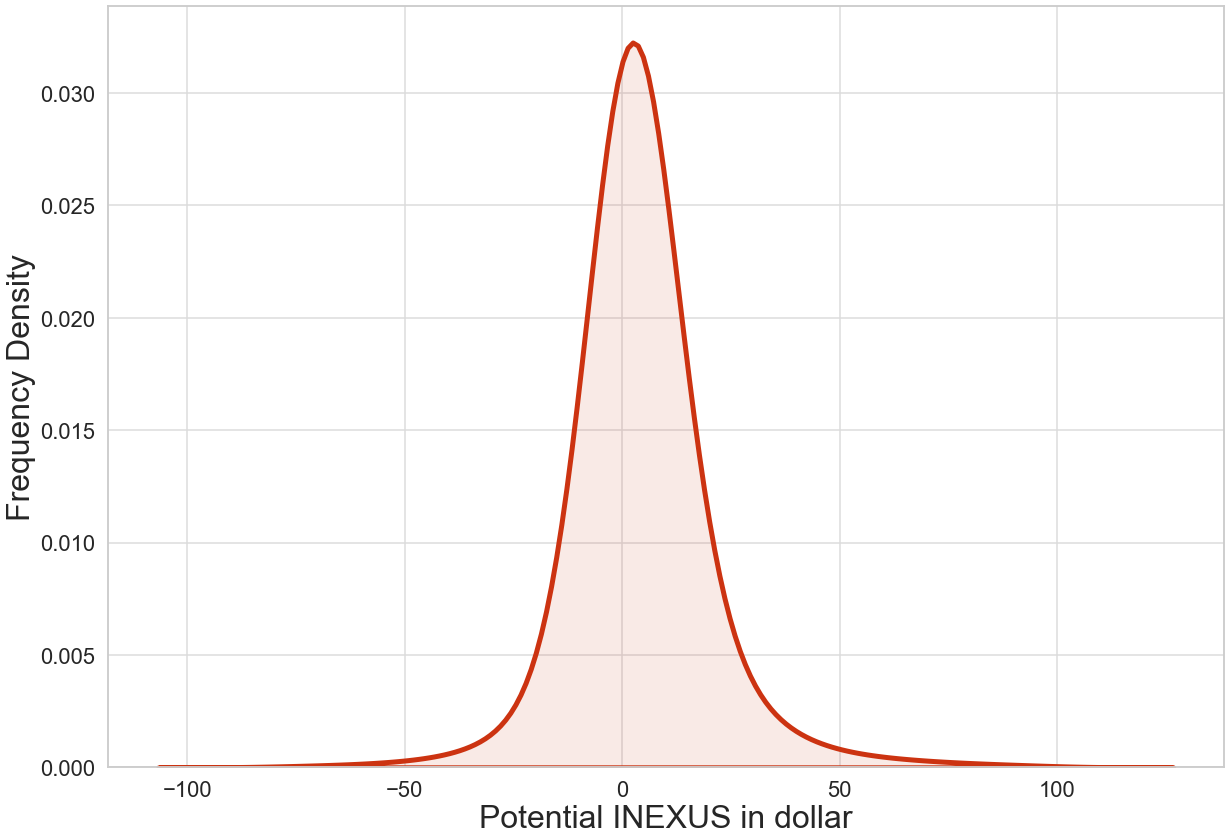

In [33]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid",{'grid.color': 'gainsboro'}) 
#'whitesmoke': a very light grey color with a hint of blue.
#'gainsboro': a very light grey color with a hint of blue-green.
#'lightgray': a slightly lighter shade of grey than 'lightgrey'.
#'lavender'

ax=sns.kdeplot(data=sfbase_plot, x="Potential_INEXUS_in_dollar_2023", 
            fill=True, common_norm=False, common_grid = False, alpha=0.1, color="#CC3311", bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

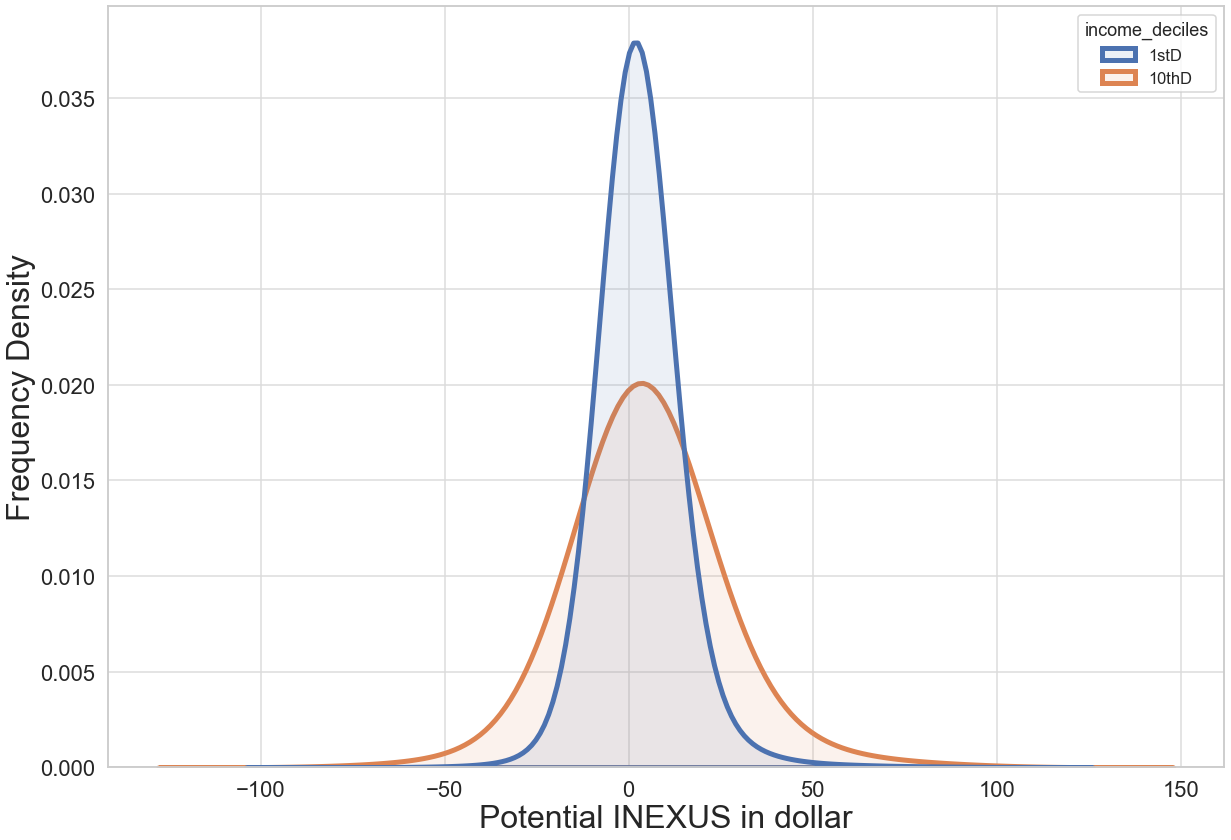

In [34]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid",{'grid.color': 'gainsboro'}) 
#'whitesmoke': a very light grey color with a hint of blue.
#'gainsboro': a very light grey color with a hint of blue-green.
#'lightgray': a slightly lighter shade of grey than 'lightgrey'.
#'lavender'

ax=sns.kdeplot(data=sfbase_plot[(sfbase_plot['income_deciles']=='1stD')|(sfbase_plot['income_deciles']=='10thD')], x="Potential_INEXUS_in_dollar_2023", 
            hue = 'income_deciles',fill=True, common_norm=False, common_grid = False, alpha=0.1, color="#CC3311", bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [23]:
sfbase['distance_walking'].mean()

852.2154319832202

In [12]:
sfbase['duration_walking'].mean()

660.2207549944501

In [11]:
sfbase[sfbase['distance_walking'] > 15000].head()

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles
60,169,55725,91317.0,76110.0,14517.0,2.891911,Home,social,13972.0,545.0,0.0,0.0,27413.547874,0.0,19281.568874,0.0,0.0,8131.979,0.0,"body-169,rideHailVehicle-828111@Uber,body-169b...",ride_hail,car,"body-169, 296512","1.0, 1.0

In [15]:
len(sfbase[(sfbase['mode_choice_actual_BEAM'] == 'walk') & (sfbase['duration_walking'] < 3600)])

110747

In [21]:
len(sfbase[(sfbase['mode_choice_actual_BEAM'] != 'walk') & (sfbase['duration_walking'] > 3600)])

59284

In [22]:
sfbase[(sfbase['mode_choice_actual_BEAM'] != 'walk') & (sfbase['duration_walking'] > 3600)].head()

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles
4,8,2893,78611.0,74530.0,4081.0,0.052631,Home,shopping,4049.0,32.0,0.0,0.0,5743.361000,0.0,5263.498000,0.0,0.0,479.863,0.0,"body-8,358648,358648,body-8",car,car,"body-8, 358648","1.0, 0.0, 0.0, 1.0",5743.361000,0,NaN,"Residen

In [20]:
len(sfbase[sfbase['mode_choice_actual_BEAM'] == 'walk'])

136449

In [18]:
len(sfbase[sfbase['duration_walking'] > 3600])

84978

In [16]:
sfbase.shape

(2482005, 269)

In [14]:
sfbase[sfbase['mode_choice_actual_BEAM'] == 'walk']['duration_walking'].mean()

2928.3958915052513

In [68]:
#sfbase_cleaned = sfbase[~((sfbase['mode_choice_actual_BEAM'] == 'walk') & (sfbase['duration_walking'] >= 3600))]

In [4]:
sfbase_cleaned_final = sfbase[(sfbase['duration_walking'] < 3600)&(sfbase['distance_walking']< 5000)
                               &(sfbase['duration_travelling']>0)]

In [76]:
sfbase_cleaned_final.shape

(2396821, 269)

In [77]:
sfbase.shape 

(2482005, 269)

In [5]:
sfbase_cleaned_final.head()

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles
0,4,1513,56512.0,56329.0,183.0,0.409358,othdiscr,Home,0.0,183.0,0.0,0.0,3732.315,0.0,0.000,0.000,0.0,3732.315,0.0,"body-4,358648,358648,body-4",car,car,"body-4, 358648","1.0, 0.0, 0.0, 1.0",3732.315,0,NaN,"Residential, Public

In [148]:
sfbase_cleaned_final.groupby('mode_choice_actual_BEAM')['marginal_emission'].sum()

KeyError: 'Column not found: marginal_emission'

In [131]:
sfbase_cleaned_final[sfbase_cleaned_final['mode_choice_actual_BEAM'] == 'hov3_teleportation']['distance_travelling'].mean()

9590.05823173544

In [95]:
sfbase_cleaned_final[(sfbase_cleaned_final['mode_choice_actual_BEAM'] == 'car')&(sfbase_cleaned_final['fuelGasoline']>0)&
                    (sfbase_cleaned_final['fuelDiesel']==0)&(sfbase_cleaned_final['fuelBiodiesel']==0)]['distance_travelling'].sum()

15810519484.689674

In [143]:
len(sfbase_cleaned_final[sfbase_cleaned_final['mode_choice_actual_BEAM'] == 'car'])

1267766

In [144]:
len(sfbase_cleaned_final[(sfbase_cleaned_final['mode_choice_actual_BEAM'] == 'car')&(sfbase_cleaned_final['fuelGasoline'] > 0)&
                    (sfbase_cleaned_final['fuelDiesel'] == 0)&(sfbase_cleaned_final['fuelBiodiesel'] == 0)
                    &(sfbase_cleaned_final['fuelElectricity'] > 0)])

1343

In [125]:
sfbase_cleaned_final.head()

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles
0,4,1513,56512.0,56329.0,183.0,0.409358,othdiscr,Home,0.0,183.0,0.0,0.0,3732.315,0.0,0.000,0.000,0.0,3732.315,0.0,"body-4,358648,358648,body-4",car,car,"body-4, 358648","1.0, 0.0, 0.0, 1.0",3732.315,0,NaN,"Residential, Public

In [103]:
diesel_car = sfbase_cleaned_final[(sfbase_cleaned_final['mode_choice_actual_BEAM'] == 'car')&(sfbase_cleaned_final['fuelDiesel'] >0)]

In [112]:
non_emg = diesel_car[~(diesel_car['vehicleIds'].str.contains('emergency'))]

In [117]:
non_emg.head()

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles
1385,3658,1200089,33606.0,33069.0,537.0,0.309672,shopping,Home,0.0,537.0,0.0,0.0,11910.450,0.0,0.000,0.0,0.0,11910.450,0.0,"body-3658,621051,621051,body-3658",car,car,"body-3658, 621051","1.0, 0.0, 0.0, 1.0",11910.450,0,NaN,"

In [115]:
emg = diesel_car[(diesel_car['vehicleIds'].str.contains('emergency'))]

In [107]:
# Check if all the vehicleid values include "emergency" word
num_emergency = diesel_car['vehicleIds'].str.contains('emergency').sum()

In [114]:
diesel_car.shape

(72655, 269)

In [108]:
num_emergency

62132

In [152]:
sfbase_cleaned_final.groupby('mode_choice_actual_BEAM')['emission_marginal'].sum()

mode_choice_actual_BEAM
bike                  0.000000
bike_transit          0.000000
car                   1.470953
car_hov2              0.238494
car_hov3              0.146015
drive_transit         0.001734
hov2_teleportation    0.000000
hov3_teleportation    0.000000
ride_hail             0.006551
ride_hail_pooled      3.898473
walk                  0.000000
walk_transit          0.000000
Name: emission_marginal, dtype: float64

In [35]:
counts= sfbase['mode_choice_actual_BEAM'].value_counts()
(counts / 2482005) * 100

car                   52.799410
car_hov2               9.313116
hov2_teleportation     8.595067
hov3_teleportation     7.744384
car_hov3               6.656352
walk_transit           6.578875
walk                   5.497531
bike                   1.370062
ride_hail              1.202496
ride_hail_pooled       0.210394
bike_transit           0.016156
drive_transit          0.016156
Name: mode_choice_actual_BEAM, dtype: float64

In [44]:
sfbase[(sfbase['mode_choice_actual_BEAM'] == 'walk')&(sfbase['fuelGasoline'] >0)]

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles
949557,2606855,855048753,51510.0,35654.0,15856.0,0.658011,work,Home,15516.0,340.0,0.0,0.0,27403.132517,0.0,21403.729517,0.0,0.0,5999.403,0.000,"body-2606855,428935,428935,GG:5186144-16MARCH-...",drive_transit,walk,"body-26068

In [60]:
sfbase.groupby('mode_choice_actual_BEAM')['emissionDiesel'].sum()

mode_choice_actual_BEAM
bike                     0.000000
bike_transit             3.637432
car                    101.488810
car_hov2                29.329870
car_hov3                22.103831
drive_transit            3.379040
hov2_teleportation       0.000000
hov3_teleportation       0.000000
ride_hail                0.252355
ride_hail_pooled         0.035997
walk                     8.272350
walk_transit          1433.617266
Name: emissionDiesel, dtype: float64

In [63]:
sfbase.head(2)

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles
0,4,1513,56512.0,56329.0,183.0,0.409358,othdiscr,Home,0.0,183.0,0.0,0.0,3732.315,0.0,0.000,0.0,0.0,3732.315,0.0,"body-4,358648,358648,body-4",car,car,"body-4, 358648","1.0, 0.0, 0.0, 1.0",3732.315,0,NaN,"Residential, Public",

In [40]:
sfbase.groupby('mode_choice_actual_BEAM')['distance_travelling'].mean()

mode_choice_actual_BEAM
bike                   4255.905055
bike_transit          13217.135656
car                   13564.642511
car_hov2              12034.634360
car_hov3              11652.380005
drive_transit         27590.608990
hov2_teleportation     9923.719643
hov3_teleportation     9589.360386
ride_hail              7893.551863
ride_hail_pooled       9242.236165
walk                   3998.427645
walk_transit          10340.960001
Name: distance_travelling, dtype: float64

In [ ]:
sfbase.head()

In [8]:
sfbase.cost_BEAM.sum()

2908295.4706831253

In [4]:
sfbase[(sfbase['mode_choice_actual_BEAM'] == 'car')&(sfbase['duration_travelling'] < 60)].shape

(21273, 269)

In [5]:
sfbase[(sfbase['mode_choice_actual_BEAM'] == 'car')&(sfbase['duration_travelling'] < 10)].shape

(2265, 269)

In [29]:
sfbase[(sfbase['mode_choice_actual_BEAM'] == 'car')&(sfbase['duration_travelling'] > 600)]['cost_BEAM'].median()

1.4099480454141

In [4]:
# Adding scenario info
sfbase['scenario'] = "baseline"
sfbase['scenario'] = sfbase['scenario'].astype("category")
sfbase['lever'] = "default"
sfbase['lever'] = sfbase['lever'].astype("category")
sfbase['year'] = 2020
sfbase['lever_position'] = 1

In [5]:
sfbase[sfbase['person_sex'].isna()].shape

(19191, 273)

In [6]:
#baseline2018 = "https://beam-core-act.s3.amazonaws.com/beam-outputs/pilates-outputs/sfbay-baseline-20221220/inexus"
#sfbase = pd.read_csv(baseline2018 + 'sfbay_baseline_default-1.0_2012__20221219.csv.gz')

In [5]:
# Showing the entire number in dataframe
pd.set_option('float_format', '{:f}'.format)

In [8]:
#describe = sfbase.describe()

In [9]:
#describe.to_csv('C:/Shared-Work/Data/CleanData/ASIM_BEAM_Merged/describe.csv')

#### Ridehail Price Scenarios

In [10]:
%%time
key = "pilates-outputs/sfbay-rh-price-0.000-20221224/inexus/sfbay_rh_price_0_000_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_0 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 44s
Wall time: 1min 44s


In [11]:
sf_rh_price_0p125[sf_rh_price_0p125['trip_mode_AS_trips'].isna()].shape

NameError: name 'sf_rh_price_0p125' is not defined

In [12]:
# Adding scenario info
sf_rh_price_0['scenario'] = "ridehail"
sf_rh_price_0['scenario'] = sf_rh_price_0['scenario'].astype("category")
sf_rh_price_0['lever'] = "price"
sf_rh_price_0['lever'] = sf_rh_price_0['lever'].astype("category")
sf_rh_price_0['year'] = 2020
sf_rh_price_0['lever_position'] = 0

In [13]:
%%time
key = "pilates-outputs/sfbay-rh-price-0.125-20221224/inexus/sfbay_rh_price_0_125_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_0p125 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 54s
Wall time: 1min 55s


In [14]:
# Adding scenario info
sf_rh_price_0p125['scenario'] = "ridehail"
sf_rh_price_0p125['scenario'] = sf_rh_price_0p125['scenario'].astype("category")
sf_rh_price_0p125['lever'] = "price"
sf_rh_price_0p125['lever'] = sf_rh_price_0p125['lever'].astype("category")
sf_rh_price_0p125['year'] = 2020
sf_rh_price_0p125['lever_position'] = 0.125

In [6]:
%%time
key = "pilates-outputs/sfbay-rh-price-0.250-20221224/inexus/sfbay_rh_price_0_250_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_0p25 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 49s
Wall time: 1min 49s


In [8]:
sfbase[sfbase['IDMerged'] == 2553015]

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles,scenario,lever,year,lever_position
928500,2553015,837388993,49108.000000,48963.000000,145.000000,0.049425,escort,Home,0.000000,145.000000,0.000000,0.000000,1900.963000,0.000000,0.000000,0.000000,0.000000,1900.963000,0.000000,

In [16]:
# Adding scenario info
sf_rh_price_0p25['scenario'] = "ridehail"
sf_rh_price_0p25['scenario'] = sf_rh_price_0p25['scenario'].astype("category")
sf_rh_price_0p25['lever'] = "price"
sf_rh_price_0p25['lever'] = sf_rh_price_0p25['lever'].astype("category")
sf_rh_price_0p25['year'] = 2020
sf_rh_price_0p25['lever_position'] = 0.25

In [4]:
%%time
s3 = boto3.client("s3")
key = "pilates-outputs/sfbay-rh-price-0.500-20221224/inexus/sfbay_rh_price_0_500_rh_price-1.0_2020__20221223.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_0p5 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:4: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 40s
Wall time: 1min 41s


In [6]:
sf_rh_price_0p5[sf_rh_price_0p5['IDMerged'] == 2984026]

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles
1086976,2984026,978760561,50477.0,47761.0,2177.0,7.551843,atwork,work,0.0,2177.0,0.0,0.0,59736.311,0.0,0.000,0.0,0.000,59736.311,0.0,"body-2984026,rideHailVehicle-3651703@Lyft,body...",ride_hail,car,"426181, body-2984026","1.

In [18]:
# Adding scenario info
sf_rh_price_0p5['scenario'] = "ridehail"
sf_rh_price_0p5['scenario'] = sf_rh_price_0p5['scenario'].astype("category")
sf_rh_price_0p5['lever'] = "price"
sf_rh_price_0p5['lever'] = sf_rh_price_0p5['lever'].astype("category")
sf_rh_price_0p5['year'] = 2020
sf_rh_price_0p5['lever_position'] = 0.5

In [19]:
%%time
key = "pilates-outputs/sfbay-rh-price-1.750-20221224/inexus/sfbay_rh_price_1_750_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_1p75 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 2min 21s
Wall time: 2min 22s


In [20]:
# Adding scenario info
sf_rh_price_1p75['scenario'] = "ridehail"
sf_rh_price_1p75['scenario'] = sf_rh_price_1p75['scenario'].astype("category")
sf_rh_price_1p75['lever'] = "price"
sf_rh_price_1p75['lever'] = sf_rh_price_1p75['lever'].astype("category")
sf_rh_price_1p75['year'] = 2020
sf_rh_price_1p75['lever_position'] = 1.75

In [21]:
%%time
key = "pilates-outputs/sfbay-rh-price-3.000-20221224/inexus/sfbay_rh_price_3_000_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_3 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 2min 30s
Wall time: 2min 30s


In [22]:
# Adding scenario info
sf_rh_price_3['scenario'] = "ridehail"
sf_rh_price_3['scenario'] = sf_rh_price_3['scenario'].astype("category")
sf_rh_price_3['lever'] = "price"
sf_rh_price_3['lever'] = sf_rh_price_3['lever'].astype("category")
sf_rh_price_3['year'] = 2020
sf_rh_price_3['lever_position'] = 3

In [23]:
%%time
key = "pilates-outputs/sfbay-rh-price-5.000-20221224/inexus/sfbay_rh_price_5_000_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_5 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 2min 39s
Wall time: 2min 40s


In [24]:
# Adding scenario info
sf_rh_price_5['scenario'] = "ridehail"
sf_rh_price_5['scenario'] = sf_rh_price_5['scenario'].astype("category")
sf_rh_price_5['lever'] = "price"
sf_rh_price_5['lever'] = sf_rh_price_5['lever'].astype("category")
sf_rh_price_5['year'] = 2020
sf_rh_price_5['lever_position'] = 5

In [25]:
%%time
key = "pilates-outputs/sfbay-rh-price-8.000-20221224/inexus/sfbay_rh_price_8_000_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_8 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 2min 43s
Wall time: 2min 43s


In [26]:
# Adding scenario info
sf_rh_price_8['scenario'] = "ridehail"
sf_rh_price_8['scenario'] = sf_rh_price_8['scenario'].astype("category")
sf_rh_price_8['lever'] = "price"
sf_rh_price_8['lever'] = sf_rh_price_8['lever'].astype("category")
sf_rh_price_8['year'] = 2020
sf_rh_price_8['lever_position'] = 8

In [27]:
#%%time
#rh_price_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Ridehail_Price/"
#sf_rh_price_0 = pd.read_csv(rh_price_path + 'sf_2018_rh_price_0.csv')
#sf_rh_price_0p25 = pd.read_csv(rh_price_path + 'sf_2018_rh_price_0p25.csv')
#sf_rh_price_0p5 = pd.read_csv(rh_price_path + 'sf_2018_rh_price_0p5.csv')
#sf_rh_price_1p5 = pd.read_csv(rh_price_path + 'sf_2018_rh_price_1p5.csv')
#sf_rh_price_2 = pd.read_csv(rh_price_path + 'sf_2018_rh_price_2.csv')

In [28]:
sfbase.shape

(2482005, 273)

In [29]:
sf_rh_price_0p25.shape

(2481634, 273)

In [30]:
#sf_rh_flsz_175 = sf_rh_flsz_175.drop(sf_rh_flsz_175.columns[245:625], axis=1)

In [ ]:
#sf_rh_flsz_175 = sf_rh_flsz_175.drop(sf_rh_flsz_175.columns[235:245], axis=1)

In [ ]:
#sf_rh_flsz_175 = sf_rh_flsz_175.drop(sf_rh_flsz_175.columns[233:235], axis=1)

In [31]:
frames = [sf_rh_price_0, sf_rh_price_0p125, sf_rh_price_0p25, sf_rh_price_0p5, sfbase, sf_rh_price_1p75, sf_rh_price_3,
         sf_rh_price_5, sf_rh_price_8]
sf_stacked = pd.concat(frames)

In [32]:
sf_stacked = sf_stacked.drop(['has_school_kid','has_preschool_kid','has_retiree','has_non_worker','adult','hispanic','relate',
                             'pstudent','pemploy','ptype','p_hispanic','age_16_p','age_16_to_19',
                             'person_age','MAR','hours','hispanic.1','student',
                             'worker','stop_frequency','composition','tdd','number_of_participants','tour_type_count',
                             'tour_type_num','tour_num','tour_count', 'outbound', 'trip_num','num_under16_not_at_school',
                             'family','non_family','num_young_adults','num_college_age','num_children_16_to_17',
                              'num_children_5_to_15','num_young_children'], axis=1)

In [33]:
sf_stacked = sf_stacked.drop(['vehicleIds_estimate','parent_tour_id','atwork_subtour_frequency','household_id_y',
                              'male','female', 'has_driving_kid','has_full_time','has_part_time',
                              'has_university','student_is_employed', 'nonstudent_to_school', 'is_student','is_gradeschool',
                              'is_gradeschool','is_highschool','is_university','school_segment','is_worker',  
                              'distance_to_school','roundtrip_auto_time_to_school',
                              'distance_to_work','workplace_in_cbd', 'work_taz_area_type', 'hh_race_of_head',
                             'roundtrip_auto_time_to_work','work_auto_savings_ratio','cdap_activity', 'travel_active', 
                              'under16_not_at_school','has_preschool_kid_at_home', 'gt2','hispanic_head',
                             'has_school_kid_at_home','work_and_school_and_worker', 'age_of_head', 'race_of_head',
                              'work_and_school_and_student', 'VEHICL','hh_children','hh_age_of_head','num_workers',
                              'gt55','seniors', 'recent_mover', 'hh_workers', 'hispanic_status_of_head', 'hh_seniors', 
                             'hh_type', 'HHT', 'sample_rate', 'chunk_id', 'income_segment', 'num_non_workers', 
                             'num_drivers', 'num_adults', 'num_children', 'hh_work_auto_savings_ratio', 'num_travel_active', 
                             'num_travel_active_adults','num_travel_active_preschoolers', 'num_travel_active_children', 
                              'num_travel_active_non_preschoolers', 'participates_in_jtf_model', 'joint_tour_frequency',
                              'num_hh_joint_tours'], axis=1)

In [34]:
sf_stacked = sf_stacked.drop(['serialno'], axis=1)

#### Stacked File

In [35]:
#stacked_tr_fr_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
#sf_stacked_tr_fr = pd.read_csv(stacked_tr_fr_path + 'sf_2018_stacked_tr_fr.csv')

In [36]:
sf_stacked = sf_stacked.sort_values(by=['IDMerged', 'tripIndex', 'lever_position']).reset_index(drop=True)

In [37]:
# shift column 'person' to first position
#first_column = sf_stacked.pop('scenario')
#second_column = sf_stacked.pop('lever')
#third_column = sf_stacked.pop('lever_position')
#fourth_column = sf_stacked.pop('logsum_trip_mode_AS_trips')
# insert column using insert(position,column_name,first_column) function
#sf_stacked.insert(2, 'scenario', first_column)
#sf_stacked.insert(3, 'lever', second_column)
#sf_stacked.insert(4, 'lever_position', third_column)
#sf_stacked.insert(5, 'logsum_trip_mode_AS_trips', fourth_column)

In [39]:
# Adding Price lever position
conditions  = [(sf_stacked['lever_position'] == 0), 
               (sf_stacked['lever_position'] == 0.125),
               (sf_stacked['lever_position'] == 0.25),
               (sf_stacked['lever_position'] == 0.5),
               (sf_stacked['lever_position'] == 1),
               (sf_stacked['lever_position'] == 1.75),
               (sf_stacked['lever_position'] == 3),
               (sf_stacked['lever_position'] == 5),
               (sf_stacked['lever_position'] == 8)]

choices = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

In [40]:
sf_stacked['lever_position_price'] = np.select(conditions, choices, default=np.nan)

In [ ]:
sf_stacked['lever_position_fleetsize'] = 1

In [ ]:
#sf_stacked_tr_fr['logsum_relative_to_baseline'] = sf_stacked_tr_fr.groupby(['IDMerged','tripIndex'])['logsum_trip_mode_AS_trips'].apply(lambda x: x.diff())

In [ ]:
#sf_stacked_tr_fr['logsum_relative_to_baseline'] = sf_stacked_tr_fr['logsum_trip_mode_AS_trips'] - sf_stacked_tr_fr.loc[sf_stacked_tr_fr.groupby(['IDMerged','tripIndex'])['lever_position'].transform('idxmin'), 'logsum_trip_mode_AS_trips'].values

In [44]:
%%time
sf_stacked['logsum_relative_to_baseline'] = sf_stacked['logsum_trip_Potential_INEXUS'] - (sf_stacked['logsum_trip_Potential_INEXUS'].where(sf_stacked['lever_position'].eq(1.0))
                                                                                                  .groupby([sf_stacked['IDMerged'],sf_stacked['tripIndex']])
                                                                                                   .transform('first')
                                                                                                   .convert_dtypes())

CPU times: total: 6.03 s
Wall time: 5.8 s


In [45]:
sf_stacked['door_to_door_time_relative_to_baseline'] = sf_stacked['duration_door_to_door'] - (sf_stacked['duration_door_to_door'].where(sf_stacked['lever_position'].eq(1.0))
                                                                                                  .groupby([sf_stacked['IDMerged'],sf_stacked['tripIndex']])
                                                                                                   .transform('first')
                                                                                                   .convert_dtypes())

In [46]:
# Drop unused columns
sf_stacked = sf_stacked.drop(['sf_detached', 'household_id_x','destination_logsum_y','logsum_tours_mode_AS_tours',
                              'primary_purpose_y','PNUM','work_auto_savings','mandatory_tour_frequency'], axis=1)

In [ ]:
sf_stacked.head()

In [47]:
sf_stacked[sf_stacked['mode_choice_actual_6'] == 'ride_hail_transit'].shape

(0, 166)

In [48]:
sf_stacked[sf_stacked['replanning_status'] > 0].shape

(338477, 166)

In [49]:
# Add the mandatory category column
mandatory = ['work' , 'univ', 'school']
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType.isin(mandatory)) & (sf_stacked.actStartType.isin(mandatory)), 'from_M_to_M' , None)

In [50]:
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType == 'Home') & (sf_stacked.actStartType.isin(mandatory)), 'from_H_to_M' , sf_stacked['mandatoryCat'])

In [51]:
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType.isin(mandatory)) & (sf_stacked.actStartType == "Home"), 'from_M_to_H' , sf_stacked['mandatoryCat'])

In [52]:
non_mandatory = ['othmaint' , 'othdiscr', 'escort', 'eatout', 'social', 'shopping', 'atwork']
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType.isin(non_mandatory)) & (sf_stacked.actStartType.isin(non_mandatory)), 'from_N_to_N' , sf_stacked['mandatoryCat'])

In [53]:
# Drop unused columns
sf_stacked = sf_stacked.drop(['num_work_tours','num_joint_tours', 'non_mandatory_tour_frequency',
                                          'num_non_mand','num_escort_tours','num_eatout_tours','num_shop_tours',
                                          'num_maint_tours','num_discr_tours','num_social_tours','num_non_escort_tours'], axis=1)

In [54]:
#sf_stacked[sf_stacked['Realized_INEXUS'].isna()].head(10000).to_csv('C:/Shared-Work/Data/CleanData/ASIM_BEAM_Merged/realizedIN_empty.csv', index = False)

In [55]:
#%%time
#sf_stacked_tr_fr.to_csv('s3://beam-core-act/deepDive/CleanData/SanFrancisco/Stacked/sf_2018_stacked_tr_fr_v3.csv', index=False)

In [56]:
sf_stacked[sf_stacked['SHARED3FREE'].isna()].shape

(178102, 156)

In [106]:
sf_stacked = sf_stacked[sf_stacked['WALK'].notna()]

In [71]:
# Mapping BEAM and ASIM modes
conditions  = [(sf_stacked['mode_choice_actual_BEAM'] == 'walk')&(sf_stacked['trip_mode_AS_trips'] == 'WALK'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'bike')&(sf_stacked['trip_mode_AS_trips'] == 'BIKE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_COM'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_stacked['trip_mode_AS_trips'] == 'TAXI'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_stacked['trip_mode_AS_trips'] == 'TAXI'),
       
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk')&((sf_stacked['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK'),
               
               ((sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sf_stacked['trip_mode_AS_trips'] == 'TAXI')|(sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sf_stacked['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_COM')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK'))),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&((sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sf_stacked['trip_mode_AS_trips'] == 'TAXI'))]
 
                                                                      
                                                                                                                 
                                                                      
choices = [sf_stacked['WALK'], sf_stacked['BIKE'], sf_stacked['SHARED3FREE'], sf_stacked['SHARED3PAY'],
           sf_stacked['SHARED3FREE'], sf_stacked['SHARED3PAY'], sf_stacked['SHARED2FREE'], 
           sf_stacked['SHARED2PAY'], sf_stacked['SHARED2PAY'], sf_stacked['SHARED2FREE'], 
           sf_stacked['DRIVEALONEFREE'], sf_stacked['DRIVEALONEPAY'], sf_stacked['WALK_LRF'], 
           sf_stacked['WALK_LOC'], sf_stacked['WALK_EXP'], sf_stacked['WALK_HVY'], sf_stacked['WALK_COM'],
           sf_stacked['TNC_SINGLE'], 
           sf_stacked['TNC_SHARED'], sf_stacked['TAXI'],
           sf_stacked['DRIVE_COM'], sf_stacked['DRIVE_LRF'], sf_stacked['DRIVE_LOC'], sf_stacked['DRIVE_EXP'],
           sf_stacked['DRIVE_HVY'], sf_stacked['TNC_SINGLE'], sf_stacked['TNC_SHARED'], sf_stacked['TAXI'],
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_stacked[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [72]:
sf_stacked['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [63]:
#sf_stacked = sf_stacked.drop(['Realized_INEXUS'], axis=1)

In [97]:
sf_stacked['Realized_INEXUS'] = np.where((sf_stacked['Realized_INEXUS'].isna())&((sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'car')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sf_stacked['Realized_INEXUS'])

In [93]:
sf_stacked['Realized_INEXUS'] = np.where((sf_stacked['Realized_INEXUS'].isna())&((sf_stacked['mode_choice_actual_BEAM'] == 'walk')|
                                         (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sf_stacked['Realized_INEXUS'])

In [100]:
sf_stacked['Realized_INEXUS'] = np.where(sf_stacked['Realized_INEXUS'].isna()&(sf_stacked['mode_choice_actual_BEAM'] == 'bike'), 
                                         sf_stacked[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sf_stacked['Realized_INEXUS'])

In [107]:
sf_stacked[sf_stacked['Realized_INEXUS'].isna()].shape

(0, 162)

In [108]:
sf_stacked[sf_stacked['Realized_INEXUS']<-1000].shape

(0, 162)

In [103]:
sf_stacked['Realized_INEXUS'] = np.where(sf_stacked['Realized_INEXUS']<-1000, sf_stacked['Realized_INEXUS']+990, sf_stacked['Realized_INEXUS'])

In [ ]:
#sf_stacked_tr_fr['Realized_INEXUS'] = np.where((sf_stacked_tr_fr['Realized_INEXUS'].isna())&
                                               #(sf_stacked_tr_fr['mode_choice_actual_BEAM'] == 'walk_transit')&
                                               #(sf_stacked_tr_fr['vehicleIds'].str.contains('(caltrain)')), 
                                               #sf_stacked_tr_fr['WALK_COM'], sf_stacked_tr_fr['Realized_INEXUS'])

In [109]:
sf_stacked = sf_stacked[sf_stacked['Realized_INEXUS'].notna()]

In [110]:
sf_stacked.head()

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_category,destination_y,origin_y,start,end,duration,tour_mode_AS_tours,age,earning,edu,race_id,sex,work_at_home,person_sex,race,TAZ_x,home_x,home_y,home_taz,value_of_time,school_taz,workplace_taz,workplace_location_logsum,free_parking_at_work,num_mand,income,tenure,hh_size,hh_cars,hh_income,tenure_mover,block_id,lcm_county_id,hhsize,TAZ_y,income_in_thousands,median_value_of_time,hh_value_of_time,home_is_urban,home_is_rural,auto_ownership,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles,scenario,lever,year,lever_position,lever_position_price,lever_position_fleetsize,logsum_relative_to_baseline,door_to_door_time_relative_to_baseline,mandatoryCat,Realized_INEXUS,alpha,socialCarbonCost,Social_INEXUS,Potential_INEXUS_in_dollar,Realized_INEXUS_in_dollar
0,4,1513,55528.000000,54961.000000,567.000000,1.604735,othdiscr,Home,0.000000,567.000000,0.000000,0.000000,14631.142000,0.000000,0.000000,0.000000,0.000000,14631.142000,0.000000,car,car,"358611, body-4","1.0, 0.0, 0.0, 1.0",14631.142000,0,NaN,"Residential, Public",0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,22701321.975947,22701321.975947,22701321.975947,60014001001.000000,-122.227937,37.854097,60014001001.000000,6001400100.000000,Oakland,Alameda County,San Francisco Bay Area (MTC),60014096004.000000,-122.171960,37.750722,60014096004.000000,6001409600.000000,Oakland,Alameda County,San Francisco Bay Area (MTC),0.000000,0.000000,0.000000,0.001678,0.000000,0.000000,567.000000,0.000000,0.000000,Home_to_othdiscr,car,car,car,1513.000000,4.000000,865.000000,189.000000,othdiscr,1.000000,othdiscr,891.000000,1005.000000,NaN,15.000000,DRIVEALONEFREE,-3.359118,othdiscr,non_mandatory,891.000000,1005.000000,15.000000,16.000000,1.000000,DRIVEALONEFREE,68.000000,0.000000,22.000000,2.000000,2.000000,0.000000,female,black,1005.000000,-122.227937,37.854097,1005.000000,2.818730,-1.000000,-1.000000,NaN,False,0.000000,70550.000000,1.000000,two,two or more,gt60-lt100,own not recent,60014001001061.000000,6001.000000,2.000000,1005.000000,70.550000,10.440000,2.818730,False,False,1.000000,-3.981448,-4.052351,-1002.981448,-1003.021964,-1002.981448,-1003.009809,-44.478549,-1009.440540,-1998.380369,-1998.380369,-1998.380369,-2002.056290,-1998.380369,-1001.227631,-1998.427241,-1998.427241,-2000.036363,-1998.427241,-29.154868,-4.326001,-5.991636,2ndQ,4thD,ridehail,price,2020,0.000000,0.000000,1,-2.571284,384.000000,None,-3.981448,0.100000,0.000000,-39.814482,-33.591179,-39.814482
1,4,1513,57775.000000,57520.000000,255.000000,0.590549,othdiscr,Home,0.000000,255.000000,0.000000,0.000000,5384.318000,0.000000,0.000000,0.000000

In [ ]:
#sf_stacked_tr_fr[sf_stacked_tr_fr['Realized_INEXUS'].isna()].to_csv('C:/Shared-Work/Data/CleanData/ASIM_BEAM_Merged/realizedIN_empty.csv', index = False)

#### Social INEXUS

In [ ]:
# add a lower and upper range for the bins in pd.cut
#quartiles = [0] + quartiles + [float('inf')]

In [ ]:
# add a quartiles column to groups, using pd.cut
#sf_stacked['income_quartiles'] = pd.cut(sf_stacked['income'], bins=quartiles, labels=['1stQ', '2ndQ', '3rdQ', '4thQ'])

In [75]:
sf_stacked['alpha'] = 0.1

In [76]:
sf_stacked['socialCarbonCost'] = sf_stacked['emission_marginal']*185 # 51 or 102

In [117]:
sf_stacked['Social_INEXUS'] = (sf_stacked['Realized_INEXUS']/sf_stacked['alpha']) - sf_stacked['socialCarbonCost']

In [118]:
sf_stacked['Potential_INEXUS_in_dollar'] = sf_stacked['logsum_trip_Potential_INEXUS']/sf_stacked['alpha']

In [119]:
sf_stacked['Realized_INEXUS_in_dollar'] = sf_stacked['Realized_INEXUS']/sf_stacked['alpha']

#### The following chunks are useful but should be checked in the next runs (they resulted in exact same realized and potential inexus in dollar

In [ ]:
# shift columns to first position
#first_column = sf_stacked.pop('Social_INEXUS')
# insert column using insert(position,column_name,first_column) function
#sf_stacked.insert(6, 'Social_INEXUS', first_column)

In [ ]:
# shift columns to first position
#first_column = sf_stacked.pop('Potential_INEXUS_in_dollar')
#second_column = sf_stacked.pop('Realized_INEXUS_in_dollar')
# insert column using insert(position,column_name,first_column) function
#sf_stacked.insert(7, 'Potential_INEXUS_in_dollar', first_column)
#sf_stacked.insert(8, 'Realized_INEXUS_in_dollar', first_column)

In [120]:
%%time
sf_stacked.to_csv('s3://beam-core-act/deepDive/CleanData/SanFrancisco/Stacked/sf_2018_stacked_rh_price_12_28_22.csv', index=False)

CPU times: total: 44min 25s
Wall time: 57min 37s
